In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [2]:
data = pd.read_csv(r"C:\Users\Meenatchi\Downloads\Ecommerce Data Classification\ecommerceDataset.csv", header=None)

In [3]:
data.shape

(50425, 2)

In [4]:
data.rename(columns={0: 'Category', 1: 'Description'}, inplace=True)

In [5]:
data.head()

,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [6]:
data.isnull().sum()

Category       0
Description    1
dtype: int64

In [7]:
data.dropna(inplace=True)

## Encoding Categorical Dependent Variable

In [10]:
data_new = pd.get_dummies(data, columns=['Category'])

In [11]:
data_new['Description'] = data_new['Description'].apply(lambda x: x.split()[:25]).apply(lambda x: ' '.join(x))

In [12]:
data_new.columns

Index(['Description', 'Category_Books', 'Category_Clothing & Accessories',
       'Category_Electronics', 'Category_Household'],
      dtype='object')

## Independent and Dependent Variables

In [13]:
X = data_new['Description']
y = data_new.drop(['Description'], axis=1)

In [14]:
X.shape

(50424,)

In [15]:
y.shape

(50424, 4)

## One Hot Representation

In [17]:
description = pd.DataFrame(X.copy())

In [18]:
description.reset_index(inplace=True)

In [19]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meenatchi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preprocessing

In [20]:
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
corpus = []
for i in range(0, len(description)):
    review = re.sub('[^a-zA-Z]', ' ', description['Description'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [21]:
voc_size = 10000

onehot_repr=[one_hot(words,voc_size)for words in corpus]

## Embedding Representation

In [23]:
sent_length=25
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2410 8099 5223]
 [   0    0    0 ... 5223 3606 8653]
 [   0    0    0 ...  538 2916 3958]
 ...
 [   0    0    0 ... 9927 7887 7303]
 [   0    0    0 ... 7660 8059 1288]
 [   0    0    0 ... 8131 4345 3718]]


## Creating Model

In [25]:
## Creating model
embedding_vector_features=30 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(4,activation='softmax'))
model.build(input_shape=(None, sent_length))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

C:\Users\Meenatchi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 25, 30)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,804 (1.35 MB)

 Trainable params: 352,804 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
len(embedded_docs),y.shape

(50424, (50424, 4))

In [27]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [28]:
X_final.shape,y_final.shape

((50424, 25), (50424, 4))

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

## Model Training

In [31]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7630 - loss: 0.6151 - val_accuracy: 0.9557 - val_loss: 0.1587
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9708 - loss: 0.1112 - val_accuracy: 0.9669 - val_loss: 0.1212
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9856 - loss: 0.0594 - val_accuracy: 0.9671 - val_loss: 0.1314
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9904 - loss: 0.0387 - val_accuracy: 0.9653 - val_loss: 0.1561
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9930 - loss: 0.0280 - val_accuracy: 0.9686 - val_loss: 0.1360
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9953 - loss: 0.0195 - val_accuracy: 0.9672 - val_loss: 0.1287
Epoch 7/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9958 - loss: 0.0171 - val_accuracy: 0.9698 - val_loss: 0.1501
Epoch 8/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9970 - loss: 0.0130 - 

## Model Prediction

In [32]:
y_pred=model.predict(X_test)

520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [33]:
y_pred=np.where(y_pred > 0.5, 1,0) ##AUC ROC Curve

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.96796875

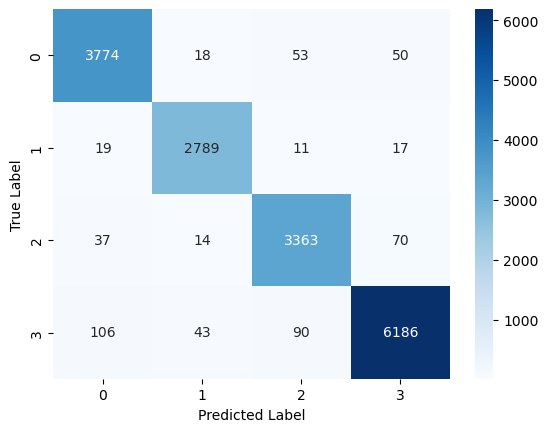

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Converting y_test and y_pred to same format
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()